# <b>Stroke Prediction Model</b>

## <b>1. Importing libraries and loading the dataset</b>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import pickle

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from tqdm.auto import tqdm

[Link for downloading the dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/download?datasetVersionNumber=1)

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## <b>2. Exploratory Data Analysis</b>

First, let's check if all the features have the correct data types:

In [3]:
df_head = df.head().T
data_types = list(df.dtypes.values)
df_head.insert(loc=0, column='data_type', value=data_types)
df_head

,data_type,0,1,2,3,4
id,int64,9046,51676,31112,60182,1665
gender,object,Male,Female,Male,Female,Female
age,float64,67.0,61.0,80.0,49.0,79.0
hypertension,int64,0,0,0,0,1
heart_disease,int64,1,0,1,0,0
ever_married,object,Yes,Yes,Yes,Yes,Yes
work_type,object,Private,Self-employed,Private,Private,Self-employed
Residence_type,object,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,float64,228.69,202.21,105.92,171.23,174.12
bmi,float64,36.6,NaN,32.5,34.4,24.0


In [4]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

The feature types are correct. However, we should exclude the <b>"Id"</b> column since it serves as a unique identifier for each individual. Also, we need to convert the <b>"Ever Married"</b> feature into a boolean format. Lastly, let's standardize the categorical values to the <b>"Snake Case"</b> format:

In [5]:
del df['id']
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int)
df.columns = df.columns.str.lower()
for column in list(df.dtypes[df.dtypes == 'object'].index):
    df[column] = df[column].str.replace(' ', '_').str.replace('-', '_').str.lower()
df

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,male,67.0,0,1,1,private,urban,228.69,36.6,formerly_smoked,1
1,female,61.0,0,0,1,self_employed,rural,202.21,NaN,never_smoked,1
2,male,80.0,0,1,1,private,rural,105.92,32.5,never_smoked,1
3,female,49.0,0,0,1,private,urban,171.23,34.4,smokes,1
4,female,79.0,1,0,1,self_employed,rural,174.12,24.0,never_smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,female,80.0,1,0,1,private,urban,83.75,NaN,never_smoked,0
5106,female,81.0,0,0,1,self_employed,urban,125.20,40.0,never_smoked,0
5107,female,35.0,0,0,1,self_employed,rural,82.99,30.6,never_smoked,0
5108,male,51.0,0,0,1,private,rural,166.29,25.6,formerly_smoked,0


Now, let's check the missing data:

In [6]:
df_isnull = pd.DataFrame(df.isnull().sum(), columns=['is_null'])
df_isna = pd.DataFrame(df.isna().sum(), columns=['is_na'])
df_isin = pd.DataFrame(df.isin(["NaN", "-", "", ".", "_", "?"]).sum(), columns=['is_in'])
pd.concat([df_isnull, df_isna, df_isin], axis=1)

,is_null,is_na,is_in
gender,0,0,0
age,0,0,0
hypertension,0,0,0
heart_disease,0,0,0
ever_married,0,0,0
work_type,0,0,0
residence_type,0,0,0
avg_glucose_level,0,0,0
bmi,201,201,0
smoking_status,0,0,0


There are some NaN values in the <b>"Body Mass Index"</b> feature. We will fill them with mean values, but after splitting the data to enhance prediction accuracy. Now, let's define the <b>numerical</b> and <b>categorical</b> features and remove the target <b>"Stroke"</b> feature:

In [7]:
numerical = list(df.columns[df.dtypes != object])
numerical.remove('stroke')
categorical = list(df.columns[df.dtypes == object])
display(numerical)
display(categorical)

['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'avg_glucose_level',
 'bmi']

['gender', 'work_type', 'residence_type', 'smoking_status']

Let's examine the values of numerical features and check for any unusual deviations:

In [8]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
ever_married,5110.0,0.656164,0.475034,0.00,0.000,1.000,1.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


There are no conspicuously high values. Now, let's examine the categorical features:

In [9]:
df[categorical].describe().T

,count,unique,top,freq
gender,5110,3,female,2994
work_type,5110,5,private,2925
residence_type,5110,2,urban,2596
smoking_status,5110,4,never_smoked,1892


The cardinality of the categorical columns are within normal limits. Here are the values:

In [10]:
for column in categorical:
    display(df[column].value_counts())

gender
female    2994
male      2115
other        1
Name: count, dtype: int64

work_type
private          2925
self_employed     819
children          687
govt_job          657
never_worked       22
Name: count, dtype: int64

residence_type
urban    2596
rural    2514
Name: count, dtype: int64

smoking_status
never_smoked       1892
unknown            1544
formerly_smoked     885
smokes              789
Name: count, dtype: int64

We've observed that the <b>"Gender"</b> column contains only one value: <b>"other"</b>, which can be safely removed. The <b>"Smoking Status"</b> feature has approximately 30% of <b>"unknown"</b> values, and it's important to retain this data for model training, so we'll continue with it.

In [11]:
df = df.drop(df[df['gender'] == 'other'].index)

### <b>Target variable</b>
It is also interesting to see the class imbalance level in our dataset:

In [12]:
df['stroke'].value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

Significant class imbalance is observed in the target variable, with <b>95%</b> belonging to <b>class "0"</b> and only <b>5%</b> to <b>class "1"</b>. Therefore, it is crucial to use the <b>ROC AUC score</b> for evaluating our models.

### <b>Feature importance</b>

#### <b>Stroke rate and risk ratio</b>
First, let's analyze which values of categorical features impact our target variable by calculating the stroke rate and stroke risk ratio parameters:

In [13]:
global_stroke_rate = df['stroke'].mean()

for column in categorical:
    print(column)
    df_group = df.groupby(column).stroke.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_stroke_rate
    df_group['abs_diff'] = np.abs(df_group['diff'])
    df_group['risk_ratio'] = df_group['mean'] / global_stroke_rate
    display(df_group.sort_values(by='risk_ratio', ascending=False))
    print()


gender


,mean,count,diff,abs_diff,risk_ratio
gender,,,,,
male,0.051064,2115,0.002326,0.002326,1.047731
female,0.047094,2994,-0.001643,0.001643,0.966282



work_type


,mean,count,diff,abs_diff,risk_ratio
work_type,,,,,
self_employed,0.079365,819,0.030628,0.030628,1.628418
private,0.050958,2924,0.002220,0.002220,1.045552
govt_job,0.050228,657,0.001491,0.001491,1.030588
children,0.002911,687,-0.045826,0.045826,0.059732
never_worked,0.000000,22,-0.048738,0.048738,0.000000



residence_type


,mean,count,diff,abs_diff,risk_ratio
residence_type,,,,,
urban,0.052003,2596,0.003266,0.003266,1.067003
rural,0.045364,2513,-0.003373,0.003373,0.930784



smoking_status


,mean,count,diff,abs_diff,risk_ratio
smoking_status,,,,,
formerly_smoked,0.079186,884,0.030448,0.030448,1.624734
smokes,0.053232,789,0.004494,0.004494,1.092217
never_smoked,0.047569,1892,-0.001169,0.001169,0.976018
unknown,0.030440,1544,-0.018297,0.018297,0.624579


#### <b>Mutual information</b>
Now, let's assess how the categorical features influence the target variable in relation to each other. The mutual information score will provide insights into these relationships:

In [14]:
def mutual_info_stroke_score(series):
    return mutual_info_score(series, df['stroke'])

In [15]:
mutual_info = df[categorical].apply(mutual_info_stroke_score)
mutual_info.sort_values(ascending=False).to_frame(name='mutual_information')

,mutual_information
work_type,0.006827
smoking_status,0.002757
residence_type,0.000119
gender,0.000041


#### <b>Correlation</b>
Next, let's have a look at the correlation coefficient, which measures the degree of dependency between two numerical variables:

In [16]:
df_corr_scores = df[numerical].corrwith(df['stroke']).sort_values(ascending=False).to_frame(name='correlation_coefficient')
df_corr_scores

,correlation_coefficient
age,0.245239
heart_disease,0.134905
avg_glucose_level,0.131991
hypertension,0.127891
ever_married,0.108299
bmi,0.042341


<Axes: >

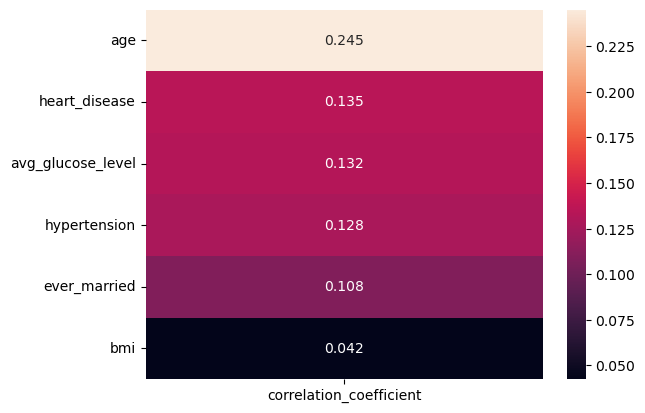

In [17]:
sns.heatmap(df_corr_scores, annot=True, fmt=".3f")

#### <b>Observations</b>
In summary of the EDA, we can make the following statements:
- **Self-employed** individuals and **former smokers** have the highest likelihood of experiencing a stroke;
- The **"Work type"** feature has the most significant impact on stroke probability compared to other features;
- The numerical feature **"Age"** exhibits the highest correlation with the target variable;
- All numerical features in our dataset exhibit positive correlations with the target variable.

### <b>Setting up the validation framework</b>
Now, let's split the data as **Train (60%)**, **Validation (20%)** and **Test (20%)** datasets and impute the missing numerical values with their respective mean values:

In [18]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle=True, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['stroke']
y_val = df_val['stroke']
y_test = df_test['stroke']

del df_train['stroke']
del df_val['stroke']
del df_test['stroke']

In [19]:
df_train['bmi'].fillna(df_train['bmi'].mean(), inplace=True)
df_val['bmi'].fillna(df_val['bmi'].mean(), inplace=True)
df_full_train['bmi'].fillna(df_full_train['bmi'].mean(), inplace=True)
df_test['bmi'].fillna(df_test['bmi'].mean(), inplace=True)

for dataset in [df_train, df_val, df_full_train, df_test]:
    display(dataset.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

## <b>3. Model training</b>
In this project we will use the next models and see, which model will give the best ROC AUC score:
- Logistic Regression;
- Decision Tree Classifier;
- Random Forest Classifier;
- Gradient Boosting Trees.


### <b>Logistic Regression Model</b>
Let's train our Logistic Regression model on a train dataset and see the score on the validation dataset:

In [20]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'Logistic Regression model score without parameters tuning is {score}')

Logistic Regression model score without parameters tuning is 0.843


It will be very informative to put all the scores into one DataFrame in order to compare the effectiveness of the different models we trained:

In [21]:
total_scores_columns = ['Algorithm', 'Parameter Tuning', 'Score']
total_scores = pd.DataFrame(columns = total_scores_columns)
current_score = {'Algorithm': 'Logistic Regression', 'Parameter Tuning': 'No', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

C:\Users\user\AppData\Local\Temp\ipykernel_16276\783696385.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_scores = total_scores._append(current_score, ignore_index=True)


,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843


### <b>Logistic Regression Model - Parameters Tuning</b>
We will use the Cross-Validation method on a Full Train dataset in order to find the best regularization parameter "C":

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)   
    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records') 
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [23]:
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
            
        y_train = df_train['stroke'].values
        y_val = df_val['stroke'].values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print(f'C = {C} {round(np.mean(scores), 3)} +- {round(np.std(scores), 3)}')

  0%|          | 0/7 [00:00<?, ?it/s]

C = 0.001 0.834 +- 0.012
C = 0.01 0.835 +- 0.012
C = 0.1 0.835 +- 0.013
C = 0.5 0.833 +- 0.014
C = 1 0.833 +- 0.014
C = 5 0.833 +- 0.014
C = 10 0.833 +- 0.015


The best score was achieved using parameter **C = 0.01**. Let's train our model on the same Train dataset using this parameter:

In [24]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(C=0.01, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'Logistic Regression model score with parameter C = 0.01 is {score}')

Logistic Regression model score with parameter C = 0.01 is 0.822


This adjustment gave us worse result. However, we will add this score to our table:

In [25]:
current_score = {'Algorithm': 'Logistic Regression', 'Parameter Tuning': 'Yes', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822


### <b>Decision Tree Model</b>
Now, let's have a look at the results the basic Decision Tree model will give us:

In [26]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = dt.predict_proba(X_val)[:, 1]
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'Decision Tree model score without parameters tuning is {score}')

Decision Tree model score without parameters tuning is 0.571


The low result was obtained due to **overfitting**, which occurs when we don't set the algorithm's **depth**. Nevertheless, let's update our table:

In [27]:
current_score = {'Algorithm': 'Decision Tree Classifier', 'Parameter Tuning': 'No', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822
2,Decision Tree Classifier,No,0.571


### <b>Desicion Tree Model - Parameters Tuning</b>
Next, let's tune the <b>max_depth</b> and <b>min_samples_leaf</b> hyperparameters:

In [28]:
scores = []

for depth in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 60]):
    for samples in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        
        auc = roc_auc_score(y_val, y_pred)      
        scores.append((depth, samples, auc))

  0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
score = df_scores_pivot.max()
df_scores_pivot.round(3)

auc                                                   \
max_depth            1      2      3      4      5      6      7      8    
min_samples_leaf                                                           
1                 0.722  0.780  0.774  0.774  0.758  0.760  0.722  0.703   
5                 0.722  0.780  0.774  0.772  0.721  0.737  0.681  0.605   
10                0.722  0.780  0.774  0.769  0.740  0.741  0.686  0.665   
15                0.722  0.780  0.774  0.769  0.719  0.723  0.675  0.687   
20                0.722  0.780  0.775  0.764  0.767  0.778  0.732  0.731   
100               0.722  0.785  0.776  0.766  0.765  0.768  0.772  0.772   
200               0.722  0.782  0.773  0.771  0.763  0.763  0.763  0.763   
500               0.722  0.779  0.777  0.777  0.777  0.777  0.777  0.777   

                                                                          
max_depth            9      10     12     15     20     30     40     60  
min_samples_leaf                                                          
1                 0.650  0.598  0.649  0.588  0.580  0.579  0.569  0.592  
5                 0.603  0.583  0.595  0.591  0.591  0.592  0.589  0.592  
10                0.669  0.671  0.665  0.676  0.676  0.675  0.665  0.676  
15                0.680  0.691  0.674  0.684  0.694  0.684  0.684  0.675  
20                0.735  0.736  0.723  0.723  0.723  0.723  0.714  0.723  
100               0.772  0.772  0.772  0.772  0.772  0.772  0.772  0.772  
200               0.763  0.763  0.763  0.763  0.763  0.763  0.763  0.763  
500               0.777  0.777  0.777  0.777  0.777  0.777  0.777  0.777

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

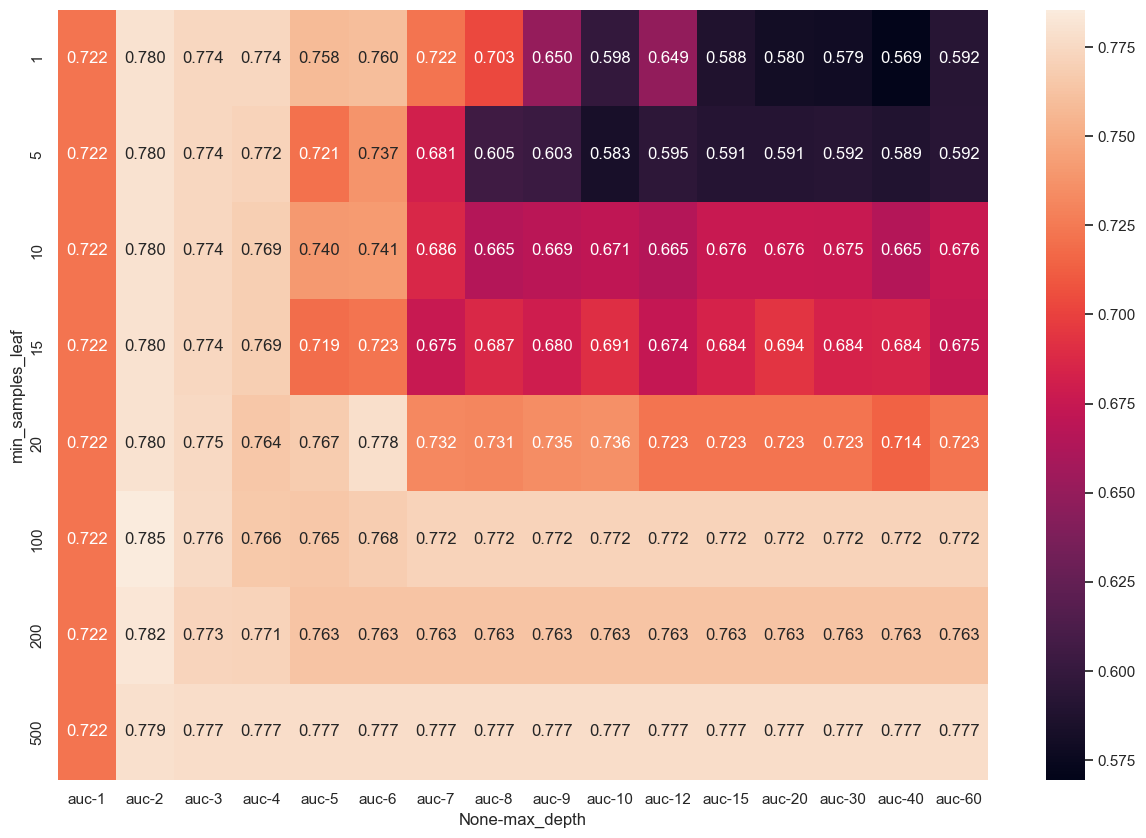

In [30]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

The best **score = 0.785** was achieved with **max_depth=2** and **min_samples_leaf=100**. Logistic Regression model result is still the best:

In [31]:
current_score = {'Algorithm': 'Decision Tree Classifier', 'Parameter Tuning': 'Yes', 'Score': 0.785}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822
2,Decision Tree Classifier,No,0.571
3,Decision Tree Classifier,Yes,0.785


### <b>Random Forest Model</b>
Let's try an example of ensemble learning - Random Forest Classifier:

In [32]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = rf.predict_proba(X_val)[:, 1]
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'Random Forest model score without parameters tuning is {score}')

Random Forest model score without parameters tuning is 0.793


Comparing to the basic Decision Tree model, Random Forest gave us a good result:

In [33]:
current_score = {'Algorithm': 'Random Forest Classifier', 'Parameter Tuning': 'No', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822
2,Decision Tree Classifier,No,0.571
3,Decision Tree Classifier,Yes,0.785
4,Random Forest Classifier,No,0.793


### <b>Random Forest Model - Parameters Tuning</b>
Next, let's tune some hyperparameters. Let's start with the <b>n_estimators</b> and <b>max_depth</b>:

In [34]:
scores = []

for depth in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 60]):
    for estimators in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = round(roc_auc_score(y_val, y_pred), 3)

        scores.append((estimators, depth, auc))

  0%|          | 0/16 [00:00<?, ?it/s]

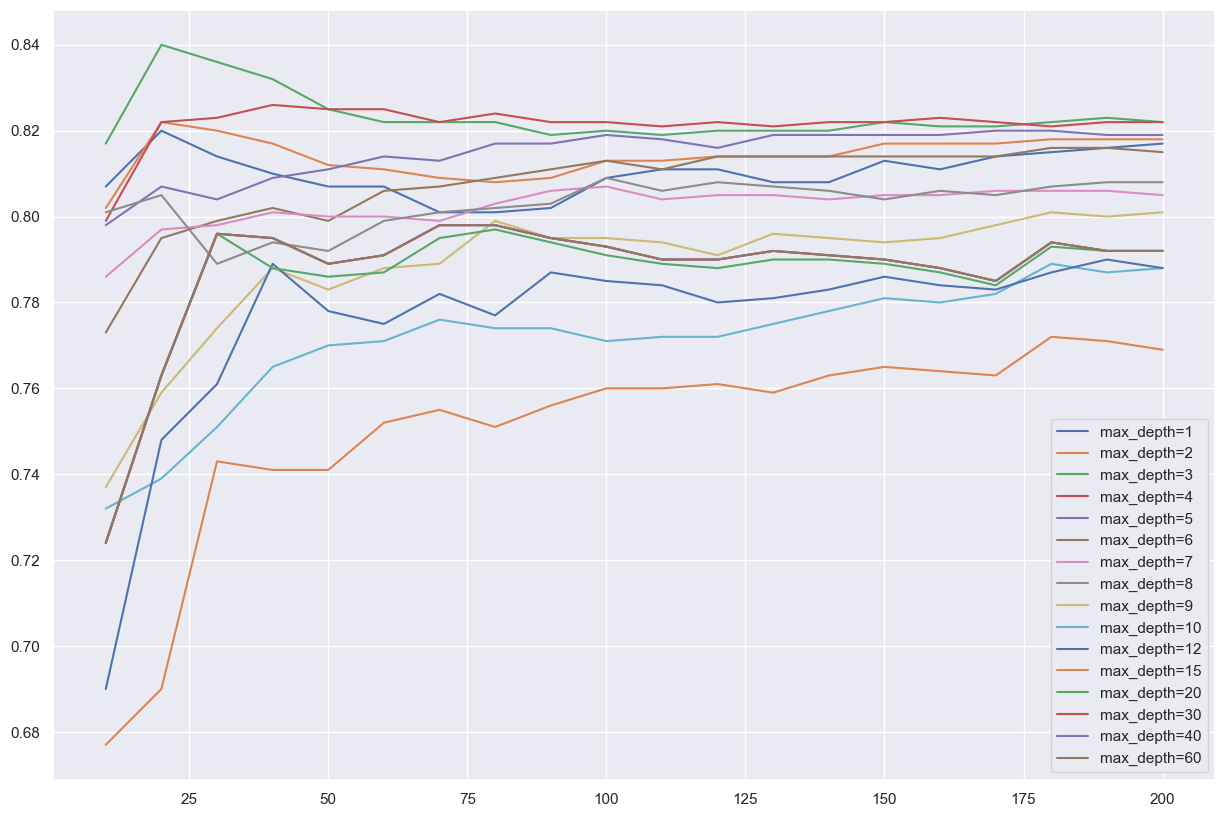

In [35]:
columns = ['n_estimators', 'max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 60]:
    df_subset = df_scores[df_scores.max_depth == depth]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % depth)

plt.legend(); 

In [36]:
df_scores[df_scores.auc == df_scores.auc.max()]

,n_estimators,max_depth,auc
41,20,3,0.84


The best result achieved during finetuning the <b>n_estimators</b> and <b>max_depth</b> parameters is **0.84**. We can set the **max_depth** to **3** and start tuning the <b>min_samples_leaf</b> parameter:

In [37]:
scores = []

for samples in tqdm([1, 5, 10, 15, 20, 500, 100, 200]):
    for estimators in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=estimators, 
                                    max_depth=3, 
                                    min_samples_leaf=samples, 
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = round(roc_auc_score(y_val, y_pred), 3)

        scores.append((estimators, samples, auc))

  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
columns = ['n_estimators', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

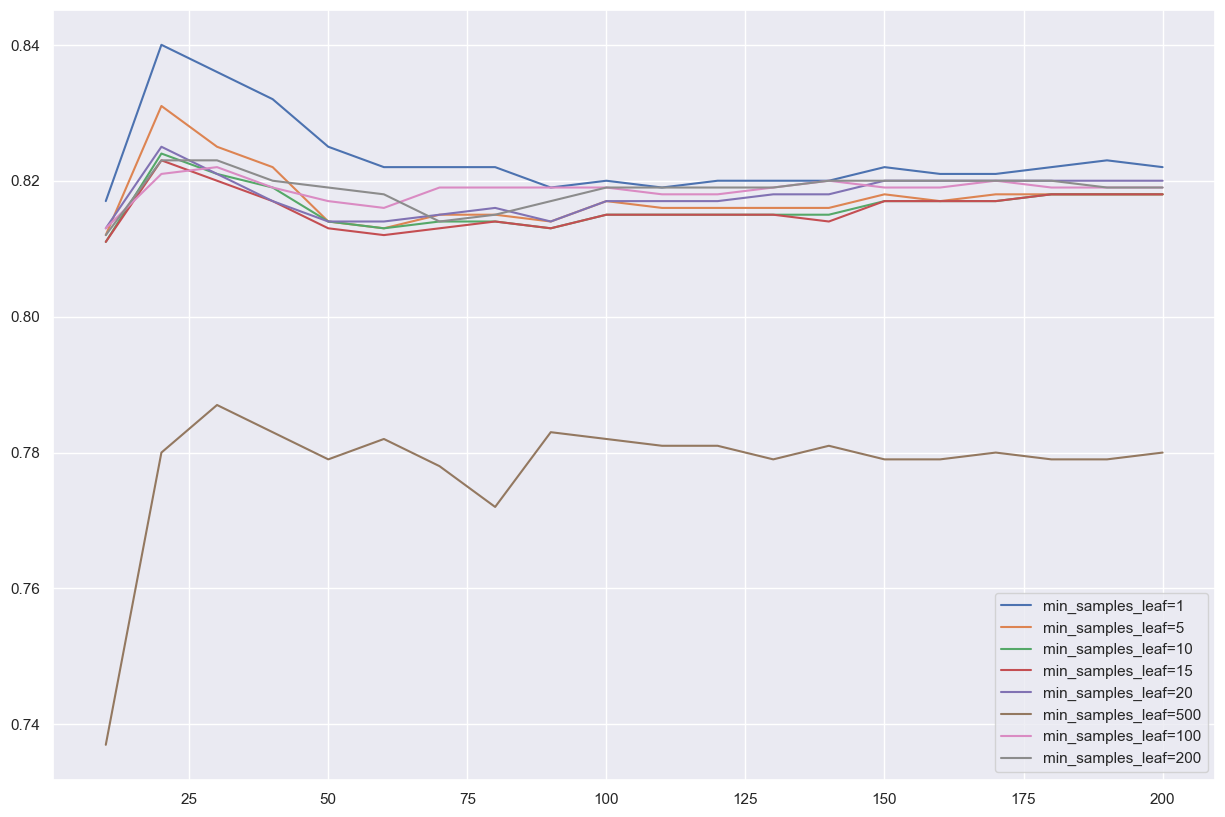

In [39]:
for samples in [1, 5, 10, 15, 20, 500, 100, 200]:
    df_subset = df_scores[df_scores.min_samples_leaf == samples]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='min_samples_leaf=%d' % samples)

plt.legend();

In [40]:
df_scores[df_scores.auc == df_scores.auc.max()]

,n_estimators,min_samples_leaf,auc
1,20,1,0.84


By searching through the hyperparameters of the Random Forest model we picked up the best values:
- **n_estimators = 20**;
- **max_depth = 3**;
- **min_samples_leaf = 1**.

Now we can train our model using these parameters and add score to the table:

In [41]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
rf = RandomForestClassifier(n_estimators=20, max_depth=3, min_samples_leaf=1, random_state=1)
rf.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = rf.predict_proba(X_val)[:, 1]
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'Random Forest model score with tuned parameters is {score}')

Random Forest model score with tuned parameters is 0.84


In [42]:
current_score = {'Algorithm': 'Random Forest Classifier', 'Parameter Tuning': 'Yes', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822
2,Decision Tree Classifier,No,0.571
3,Decision Tree Classifier,Yes,0.785
4,Random Forest Classifier,No,0.793
5,Random Forest Classifier,Yes,0.840


### <b>Gradient Boosting Trees</b>
As our final model let's try a Gradient Boosting model and see how it's results compare to the others. First, we will use the default parameters:

In [43]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['iterations', 'train_score', 'val_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [44]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,    
    'objective': 'binary:logistic',
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'XGBoost model score without parameters tuning is {score}')

XGBoost model score without parameters tuning is 0.771


The result, which XGBoost model achieved, can be much better if we will tune the hyperparameters. First, let's add it to our table:

In [45]:
current_score = {'Algorithm': 'Gradient Boosting Trees', 'Parameter Tuning': 'No', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822
2,Decision Tree Classifier,No,0.571
3,Decision Tree Classifier,Yes,0.785
4,Random Forest Classifier,No,0.793
5,Random Forest Classifier,Yes,0.840
6,Gradient Boosting Trees,No,0.771


### <b>Gradient Boosting Trees - Parameters Tuning</b>
Now, we will tune the Gradient Boosting model hyperparameters and see if the result can beat our leaderboard:

In [46]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

Let's start the tuning process from **"eta"** hyperparameter:

In [47]:
scores = {}
eta = [0.01, 0.1, 0.3, 0.5, 1]

In [48]:
%%capture output

xgb_params = {
    'eta': eta[0], 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [49]:
key = f'eta = {eta[0]}'
scores[key] = parse_xgb_output(output)

In [50]:
%%capture output

xgb_params['eta'] = eta[1]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [51]:
key = f'eta = {eta[1]}'
scores[key] = parse_xgb_output(output)

In [52]:
%%capture output

xgb_params['eta'] = eta[2]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [53]:
key = f'eta = {eta[2]}'
scores[key] = parse_xgb_output(output)

In [54]:
%%capture output

xgb_params['eta'] = eta[3]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [55]:
key = f'eta = {eta[3]}'
scores[key] = parse_xgb_output(output)

In [56]:
%%capture output

xgb_params['eta'] = eta[4]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [57]:
key = f'eta = {eta[4]}'
scores[key] = parse_xgb_output(output)

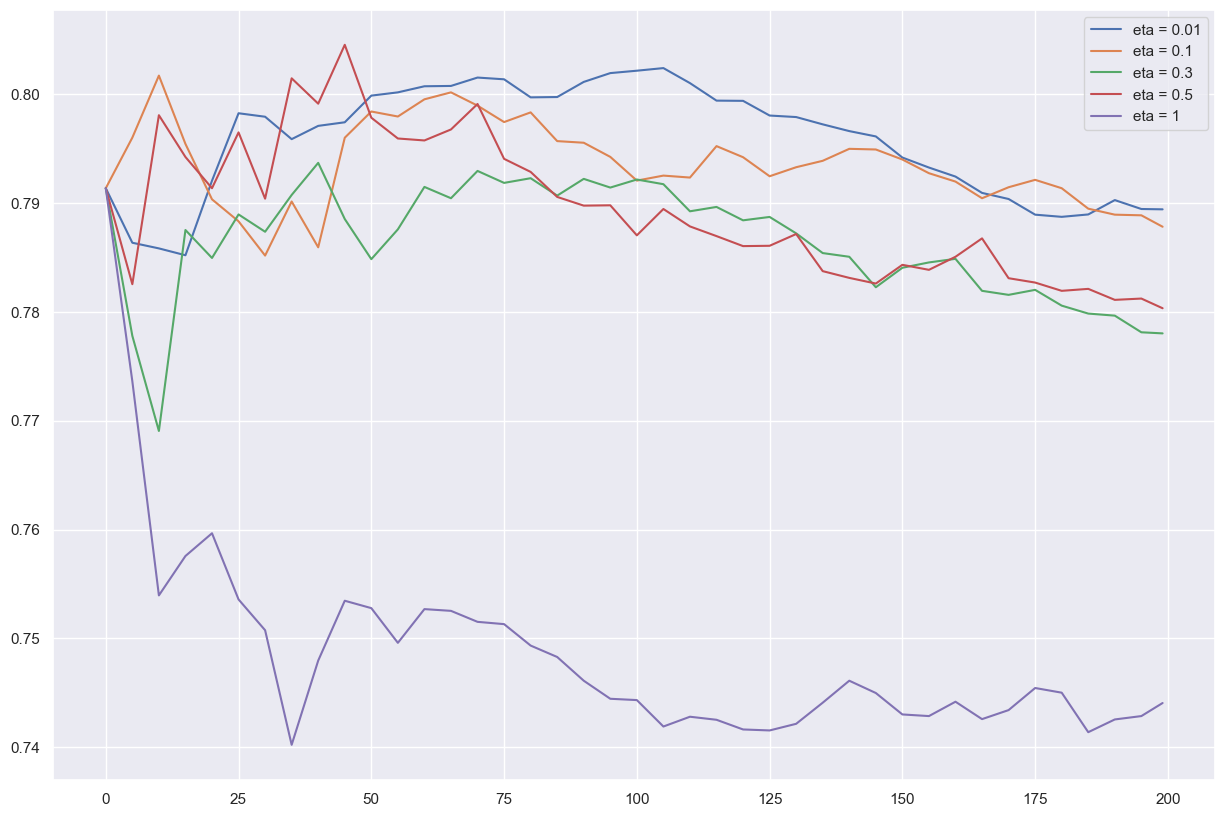

In [58]:
for key, df_score in scores.items():
    plt.plot(df_score.iterations, df_score.val_score, label=key)
plt.legend();

In [59]:
df_score = scores['eta = 0.5']
df_score[df_score.val_score == df_score.val_score.max()]

,iterations,train_score,val_score
9,45,0.99997,0.80455


Parameter **eta = 0.5** showed the best result. Next, we will tune the **max_depth**:

In [60]:
scores = {}
depth = [1, 2, 3, 5, 8, 13, 21]

In [61]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': depth[0],
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [62]:
key = f'max_depth = {depth[0]}'
scores[key] = parse_xgb_output(output)

In [63]:
%%capture output

xgb_params['max_depth'] = depth[1]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [64]:
key = f'max_depth = {depth[1]}'
scores[key] = parse_xgb_output(output)

In [65]:
%%capture output

xgb_params['max_depth'] = depth[2]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [66]:
key = f'max_depth = {depth[2]}'
scores[key] = parse_xgb_output(output)

In [67]:
%%capture output

xgb_params['max_depth'] = depth[3]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [68]:
key = f'max_depth = {depth[3]}'
scores[key] = parse_xgb_output(output)

In [69]:
%%capture output

xgb_params['max_depth'] = depth[4]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [70]:
key = f'max_depth = {depth[4]}'
scores[key] = parse_xgb_output(output)

In [71]:
%%capture output

xgb_params['max_depth'] = depth[5]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [72]:
key = f'max_depth = {depth[5]}'
scores[key] = parse_xgb_output(output)

In [73]:
%%capture output

xgb_params['max_depth'] = depth[6]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [74]:
key = f'max_depth = {depth[6]}'
scores[key] = parse_xgb_output(output)

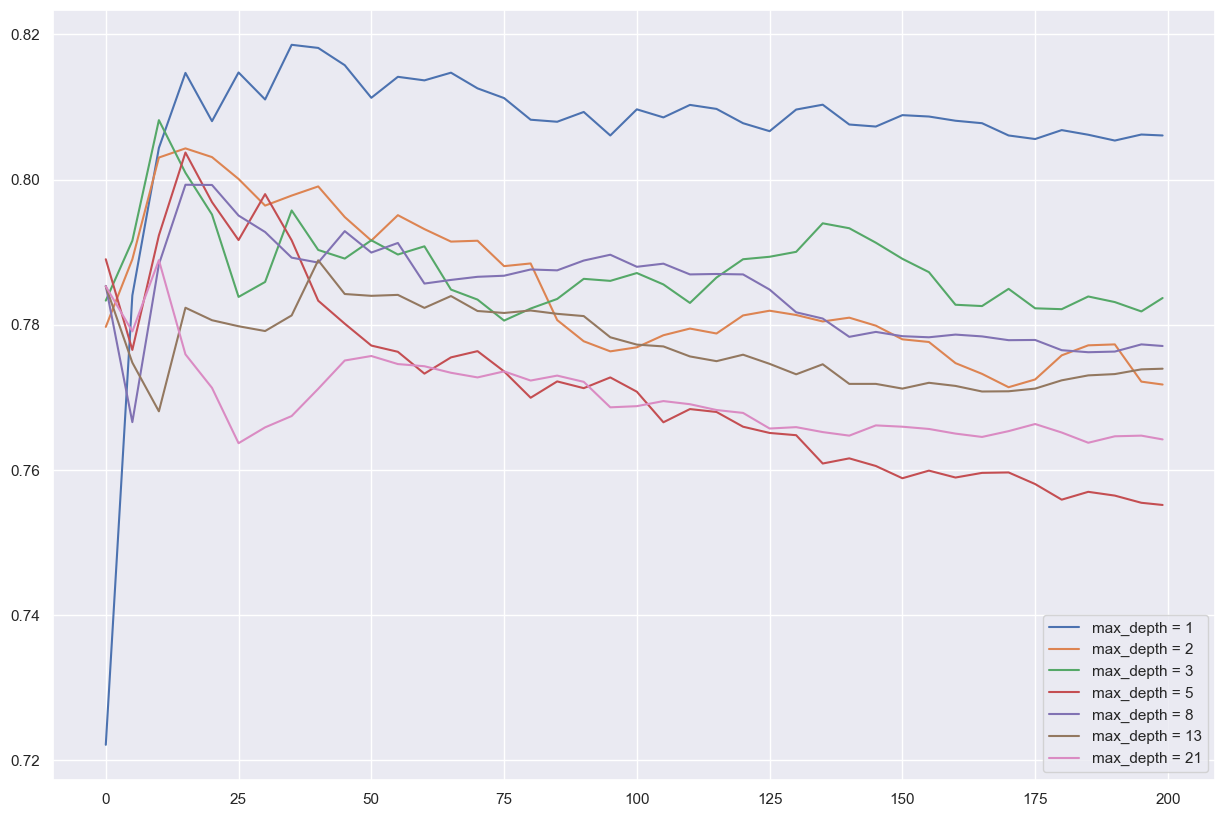

In [75]:
for key, df_score in scores.items():
    plt.plot(df_score.iterations, df_score.val_score, label=key)
plt.legend();

In [76]:
df_score = scores['max_depth = 1']
df_score[df_score.val_score == df_score.val_score.max()]

,iterations,train_score,val_score
7,35,0.8742,0.81857


Result of our model has slightly improved with the **max_depth = 1**. Let's try different variations of the **min_child_weight** parameter:

In [77]:
scores = {}
weight = [1, 2, 3, 4, 5, 10, 20, 30]

In [78]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 1,
    'min_child_weight': weight[0],
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [79]:
key = f'min_child_weight = {weight[0]}'
scores[key] = parse_xgb_output(output)

In [80]:
%%capture output

xgb_params['min_child_weight'] = weight[1]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [81]:
key = f'min_child_weight = {weight[1]}'
scores[key] = parse_xgb_output(output)

In [82]:
%%capture output

xgb_params['min_child_weight'] = weight[2]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [83]:
key = f'min_child_weight = {weight[2]}'
scores[key] = parse_xgb_output(output)

In [84]:
%%capture output

xgb_params['min_child_weight'] = weight[3]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [85]:
key = f'min_child_weight = {weight[3]}'
scores[key] = parse_xgb_output(output)

In [86]:
%%capture output

xgb_params['min_child_weight'] = weight[4]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [87]:
key = f'min_child_weight = {weight[4]}'
scores[key] = parse_xgb_output(output)

In [88]:
%%capture output

xgb_params['min_child_weight'] = weight[5]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [89]:
key = f'min_child_weight = {weight[5]}'
scores[key] = parse_xgb_output(output)

In [90]:
%%capture output

xgb_params['min_child_weight'] = weight[6]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [91]:
key = f'min_child_weight = {weight[6]}'
scores[key] = parse_xgb_output(output)

In [92]:
%%capture output

xgb_params['min_child_weight'] = weight[7]
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [93]:
key = f'min_child_weight = {weight[7]}'
scores[key] = parse_xgb_output(output)

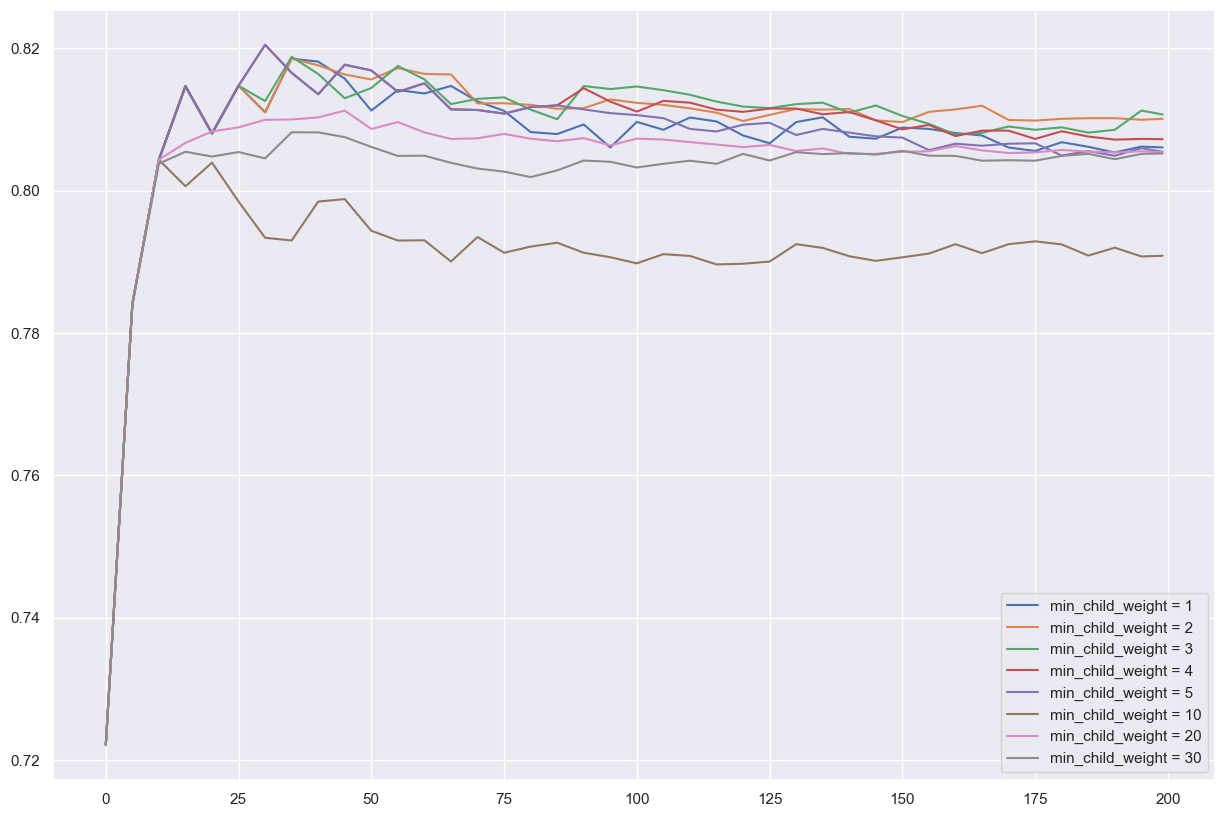

In [94]:
for key, df_score in scores.items():
    plt.plot(df_score.iterations, df_score.val_score, label=key)
plt.legend();

In [95]:
df_score = scores['min_child_weight = 5']
df_score[df_score.val_score == df_score.val_score.max()]

,iterations,train_score,val_score
6,30,0.87219,0.82051


Hyperparameters tuning of our Gradient Boosting model improved the result, achieved within default parameters. Here are the best values:
- **eta = 0.5**;
- **max_depth = 1**;
- **min_child_weight = 5**.

Let's train the whole model using these parameters and add the score to our table:

In [96]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.5, 
    'max_depth': 1,
    'min_child_weight': 5,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)
y_pred = model.predict(dval)
score = round(roc_auc_score(y_val, y_pred), 3)
print(f'XGBoost model score with tuned parameters is {score}')

XGBoost model score with tuned parameters is 0.805


In [97]:
current_score = {'Algorithm': 'Gradient Boosting Trees', 'Parameter Tuning': 'Yes', 'Score': score}
total_scores = total_scores._append(current_score, ignore_index=True)
total_scores

,Algorithm,Parameter Tuning,Score
0,Logistic Regression,No,0.843
1,Logistic Regression,Yes,0.822
2,Decision Tree Classifier,No,0.571
3,Decision Tree Classifier,Yes,0.785
4,Random Forest Classifier,No,0.793
5,Random Forest Classifier,Yes,0.840
6,Gradient Boosting Trees,No,0.771
7,Gradient Boosting Trees,Yes,0.805


### <b>Best Model Selection and Obtaining the Final Result</b>
According to our score table, we can choose the best model. This is the **Logistic Regression** with default parameters. Now, we can train our model on a Full Train data and get the final result on a Test data.

In [98]:
y_full_train = df_full_train['stroke']
del df_full_train['stroke']
df_full_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,male,79.0,1,0,1,self_employed,urban,72.04,23.6,formerly_smoked
1,female,74.0,0,0,1,self_employed,urban,68.18,27.3,formerly_smoked
2,female,34.0,0,0,1,private,rural,174.37,23.0,never_smoked
3,male,80.0,0,0,1,private,rural,56.99,26.7,never_smoked
4,female,49.0,0,0,1,private,rural,85.23,25.4,unknown


In [99]:
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)
model = LogisticRegression(max_iter=1000)
model.fit(X_full_train, y_full_train)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)
y_pred = model.predict_proba(X_test)[:, 1]
score = round(roc_auc_score(y_test, y_pred), 3)
print(f'Final Logistic Regression model score on a Test dataset is {score}')

Final Logistic Regression model score on a Test dataset is 0.85


### <b>Final Conclusion</b>
In order to predict the stroke probability we trained a Logistic Regression model and achieved a decent result. Now we can start deploying our model to the server.